In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import torch.nn as nn
import json
import os
import random
import torch

from collections import Counter, defaultdict
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seeds to reproduce results
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

%matplotlib inline

GPU is available
GPU is available


Using TensorFlow backend.


# Experiment 3

In [5]:
# define experiment
exp='/exp_3'

# define subexperiment (this time, there are two different datasets)
subexp= '/turn_left' #'/jump'

# define number of iterations
n_iters = 20000

# define batch size
batch_size = 32

In [6]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# experiment 3 #

# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, 
                                                                                                    split='/train', 
                                                                                                    subexp=subexp)
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, 
                                                      split='/test', 
                                                      subexp=subexp)

In [9]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 21890
Number of test source-target pairs: 1208


In [10]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['jump', 'twice', 'after', 'run', 'right', 'thrice']
Action: ['I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_JUMP', 'I_JUMP']


In [11]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['look', 'around', 'left', 'and', 'turn', 'left', 'thrice']
Action: ['I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT']


In [12]:
# create command-action pairs for cosine sim computation
rep_cmds_str = ['run', 'jump', 'run twice', 'jump twice']
rep_cmds, rep_acts = [], []
for cmd in rep_cmds_str:
    cmd = cmd.split()
    rep_cmds.append(cmd)
    rep_acts.append(semantic_mapping(cmd))

## Prepare data

In [13]:
cmds_train, acts_train, input_lengths_train, masks = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts, 
                                                               padding=True, training=True, reverse_source=False)

cmds_test, acts_test, input_lengths_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts, 
                                                     padding=True, training=False, reverse_source=False)

rep_cmds, rep_acts, input_lengths_rep = pairs2idx(rep_cmds, rep_acts, w2i_cmds, w2i_acts,
                                                  padding=True, training=False, reverse_source=False)

In [14]:
# create train and test data loaders
train_dl = create_batches(cmds_train, acts_train, input_lengths_train, batch_size=batch_size,
                          masks=masks, split='train', num_samples=n_iters)

test_dl = create_batches(cmds_test, acts_test, input_lengths_test, batch_size=batch_size, split='test')

cosine_dl = create_batches(rep_cmds, rep_acts, input_lengths_rep, batch_size=len(rep_cmds_str), split='test')

In [ ]:
### Hyperparameters for training ###

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_sizes = [10, 20]

# size of hidden units
hidden_sizes = [50, 100]

# number of layers
layer_sizes = [1, 2]

# layer dropout rates
dropout_rates = [0.25, 0.5]

# learning rate
lr = 1e-3

# define whether encoder is uni- or bidirectional (decoder cannot be bidirectional)
bidir = True

# number of epochs
n_epochs = 10 # 10-15 epochs (20.000 iterations each) seem to be sufficient to let models converge (find local minima)

## Grid search over specified hyperparameter space

In [ ]:
def grid_search(in_size:int, out_size:int, embedding_sizes:list, hidden_sizes:list, layer_sizes:list, 
                dropout_rates:list, lr:float, n_epochs:int):
    batch_size = 32
    grid_results = defaultdict(dict)
    for emb_size in embedding_sizes:
        for hidden_size in hidden_sizes:
            for layer_size in layer_sizes:
                for dropout_rate in dropout_rates:
                    # instantiate models
                    encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, bidir=False)
                    decoder = DecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)
                    # move models to GPU, if nvidia GPU is available (faster computation)
                    encoder.cuda()
                    decoder.cuda()
                    # train
                    train_losses, train_accs, encoder, decoder = train(train_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts,
                                                                       encoder, decoder, epochs=n_epochs,
                                                                       batch_size=batch_size, learning_rate=lr,
                                                                       detailed_analysis=False)
                    # test
                    test_acc = test(test_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder,
                                    batch_size=batch_size, detailed_analysis=True, detailed_results=False)
                    # store results (convert keys to str to save results as .json file)
                    grid_results[str((emb_size, hidden_size, layer_size, dropout_rate))]['train_accs'] = train_accs
                    grid_results[str((emb_size, hidden_size, layer_size, dropout_rate))]['train_losses'] = train_losses
                    grid_results[str((emb_size, hidden_size, layer_size, dropout_rate))]['test_acc'] = test_acc
    return grid_results

In [ ]:
grid_results = grid_search(in_size, out_size, embedding_sizes, hidden_sizes, layer_sizes, dropout_rates, lr, n_epochs)

In [ ]:
# save results in .json file
with open('./results/experiment_2_GRU_grid_search.json', 'w') as json_file:
      json.dump(grid_results_copy, json_file)

In [ ]:
test_accs = {hypers: results['test_acc'] for hypers, results in grid_results.items()}
test_accs = dict(sorted(test_accs.items(), key=lambda kv:kv[1], reverse=False))

## Debugging

In [15]:
## Hyperparameters for final model ##

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_size = 10

# size of hidden units
hidden_size = 100

# number of layers
layer_size = 1

# layer dropout rates
dropout_rate = 0.5

# learning rate
lr = 1e-3

# define whether encoder is uni- or bidirectional (decoder cannot be bidirectional)
bidir = False

# max source sequence length
max_cmd_length = cmds_train.shape[1]

# number of epochs
n_epochs = 12 # 10-15

In [16]:
## Instantiate models ##

encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, 
                     max_source_length=max_cmd_length, bidir=bidir)

#decoder = DecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)

decoder = AttnDecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate, 
                         attention_version='multiplicative')

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [28]:
## move models to GPU, if GPU is available (for faster computation) ##

In [17]:
encoder.cuda()

EncoderGRU(
  (embedding): Embedding(16, 10, padding_idx=0)
  (gru): GRU(10, 100, batch_first=True, dropout=0.5)
)

In [18]:
decoder.cuda()

AttnDecoderGRU(
  (embedding): Embedding(9, 10, padding_idx=0)
  (attention): MultiplicativeAttention(
    (attn): Linear(in_features=100, out_features=100, bias=True)
  )
  (linear): Linear(in_features=200, out_features=9, bias=True)
  (gru): GRU(10, 100, batch_first=True, dropout=0.5)
)

### Training

In [ ]:
train_losses, train_accs, command_hiddens, encoder, decoder = train(train_dl,
                                                                   w2i_cmds, w2i_acts,
                                                                   i2w_cmds, i2w_acts,
                                                                   encoder, decoder,
                                                                   epochs= n_epochs,
                                                                   batch_size=batch_size,
                                                                   learning_rate=lr,
                                                                   detailed_analysis=False,
                                                                   detailed_results=False,
                                                                   similarity_computation=True)

Epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]

Train loss: 0.8936410900474603
Train acc: 0.00165
Current teacher forcing ratio 0.95


Epoch:   8%|██████▎                                                                    | 1/12 [05:04<55:53, 304.88s/it]

### Testing

In [ ]:
# simple evaluation

#test_acc = test(test_dl,
#                w2i_cmds, w2i_acts, 
#                i2w_cmds, i2w_acts,
#                encoder, decoder,
#                batch_size=batch_size,
#                detailed_analysis=False,
#                detailed_results=False,
#                components_accuracy=False)

## more fine-grained analysis ##

test_acc, acc_per_component, errors_per_component = test(test_dl,
                                                        w2i_cmds, w2i_acts, 
                                                        i2w_cmds, i2w_acts,
                                                        encoder, decoder,
                                                        batch_size=batch_size,
                                                        detailed_analysis=False,
                                                        detailed_results=False,
                                                        components_performance=True)

## Deeper analyses of model behaviour

### Jump (trained in isolation)

#### Display per-component-accuracy

In [ ]:
#print(acc_per_component)

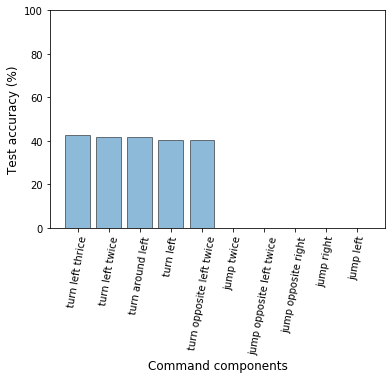

In [33]:
n = 5
top_and_bottom_n = dict(list(acc_per_component.items())[:n] + list(acc_per_component.items())[-n:])
plt.bar(top_and_bottom_n.keys(), top_and_bottom_n.values(), alpha=0.5, edgecolor='black')
plt.xlabel('Command components', fontsize=12)
plt.ylabel('Test accuracy (%)', fontsize=12)
plt.yticks(np.arange(0, 120, 20))
plt.xticks(ticks=range(len(top_and_bottom_n)), labels=list(top_and_bottom_n.keys()), rotation=80)
plt.show()

#### Display per-component-errors

In [ ]:
#print(errors_per_component)

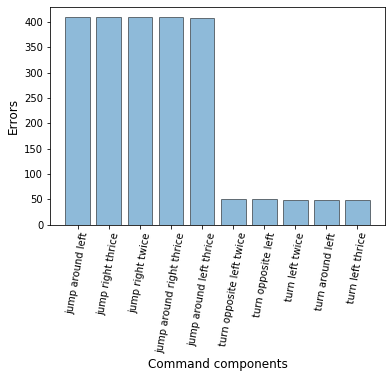

In [34]:
n = 5
top_and_bottom_n = dict(list(errors_per_component.items())[:n] + list(errors_per_component.items())[-n:])
plt.bar(top_and_bottom_n.keys(), top_and_bottom_n.values(), alpha=0.5, edgecolor='black')
plt.xlabel('Command components', fontsize=12)
plt.ylabel('Errors', fontsize=12)
plt.xticks(ticks=range(len(top_and_bottom_n)), labels=list(top_and_bottom_n.keys()), rotation=80)
plt.show()

#### Show cosine similarities between hidden states of different training commands

In [42]:
train_dl = create_batches(cmds_train, acts_train, input_lengths_train, batch_size=batch_size, 
                          split='train', compute_cosines=True)

In [51]:
train_command_hiddens = get_encoder_hiddens(train_dl, encoder, i2w_cmds, batch_size = batch_size)
rep_command_hiddens = get_encoder_hiddens(cosine_dl, encoder, i2w_cmds, batch_size = len(rep_cmds_str))

In [74]:
nearest_neighbours_per_cmd = get_nearest_neighbours(train_command_hiddens, rep_command_hiddens)

for df in nearest_neighbours_per_cmd:
    print(df.head())
    #print(df.to_latex())
    print()

                          run twice
run thrice                 0.944205
run and run twice          0.939585
walk right and run twice   0.933791
run left and run twice     0.933221
walk left and run twice    0.931251

                     jump twice
jump                   0.850520
turn right twice       0.763464
turn opposite right    0.755152
turn left twice        0.754299
turn opposite left     0.753873

                         run
run and run         0.924196
run after run       0.923371
run right and run   0.910010
run left and run    0.907019
walk right and run  0.904306

                                         jump
turn right                           0.691315
turn left                            0.650275
run after turn right                 0.622777
run after turn left                  0.622418
turn opposite left after turn right  0.614905



In [ ]:
#command = 'run'
#nearest_neighbours = compute_similarities(command_hiddens, command)
#df = pd.DataFrame.from_dict(nearest_neighbours, orient='index', columns=[command])
#df.head()

In [ ]:
#command = 'jump'
#nearest_neighbours = compute_similarities(command_hiddens, command)
#df = pd.DataFrame.from_dict(nearest_neighbours, orient='index', columns=[command])
#df.head()

In [ ]:
#command = 'run twice'
#nearest_neighbours = compute_similarities(command_hiddens, command)
#df = pd.DataFrame.from_dict(nearest_neighbours, orient='index', columns=[command])
#df.head()

In [ ]:
#command = 'jump twice'
#nearest_neighbours = compute_similarities(command_hiddens, command)
#df = pd.DataFrame.from_dict(nearest_neighbours, orient='index', columns=[command])
#df.head()

### Turn left (trained compositionally)

#### Display per-component-accuracy

In [ ]:
n = 5
top_and_bottom_n = dict(list(acc_per_component.items())[:n] + list(acc_per_component.items())[-n:])
plt.bar(top_and_bottom_n.keys(), top_and_bottom_n.values(), alpha=0.5, edgecolor='black')
plt.xlabel('Command components', fontsize=12)
plt.ylabel('Test accuracy (%)', fontsize=12)
plt.yticks(np.arange(0, 120, 20))
plt.xticks(ticks=range(len(top_and_bottom_n)), labels=list(top_and_bottom_n.keys()), rotation=80)
plt.show()

#### Display per-component-errors

In [ ]:
n = 5
top_and_bottom_n = dict(list(errors_per_component.items())[:n] + list(errors_per_component.items())[-n:])
plt.bar(top_and_bottom_n.keys(), top_and_bottom_n.values(), alpha=0.5, edgecolor='black')
plt.xlabel('Command components', fontsize=12)
plt.ylabel('Errors', fontsize=12)
plt.xticks(ticks=range(len(top_and_bottom_n)), labels=list(top_and_bottom_n.keys()), rotation=80)
plt.show()

#### Show cosine similarities between hidden states of different training commands

In [ ]:
train_dl = create_batches(cmds_train, acts_train, input_lengths_train, batch_size=batch_size, 
                          split='train', compute_cosines=True)

In [ ]:
train_command_hiddens = get_encoder_hiddens(train_dl, encoder, i2w_cmds, batch_size = batch_size)
rep_command_hiddens = get_encoder_hiddens(cosine_dl, encoder, i2w_cmds, batch_size = len(rep_cmds_str))

In [ ]:
nearest_neighbours_per_cmd = get_nearest_neighbours(train_command_hiddens, rep_command_hiddens)

for df in nearest_neighbours_per_cmd:
    print(df.head())
    #print(df.to_latex())
    print()